### Dataset
[1](https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
[2](http://vis-www.cs.umass.edu/lfw/)
[3](https://www.cs.tau.ac.il/~wolf/ytfaces/)


In [1]:
# !wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -P data
# !tar -xzf data/lfw-deepfunneled.tgz -C data

In [2]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import functools 
import operator 
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
from exitai.learner import Learner
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
image_folder = datasets.ImageFolder('data/lfw-deepfunneled')

In [4]:
class FIWDataset(DataLoader):
    def __init__(self, data_image, transform):
        self.dict_classes = {}
        self.imgs_anchor = []
        
        # load img and add to class dict
        for path, index_class in data_image:
            if index_class not in self.dict_classes:
                self.dict_classes[index_class] = []
            image = transform(Image.open(path))
            self.dict_classes[index_class].append(image)
        
        # keep all multiple images in the class to use it as Anchor images
        for idx in self.dict_classes.keys():
            num_img = len(self.dict_classes[idx])
            if num_img > 1:
                imgs_data = [(idx, img) for img in self.dict_classes[idx]]
                self.imgs_anchor.extend(imgs_data)
        
    def __getitem__(self, index):
        # anchor
        class_anchor, img_anchor = self.imgs_anchor[index]
        
        # positive
        img_pos = random.choice(self.dict_classes[class_anchor])
        while img_pos is img_anchor:
            img_pos = random.choice(self.dict_classes[class_anchor])
            
        # negative
        class_neg = random.choice(list(self.dict_classes.keys()))
        while class_neg is class_anchor:
            class_neg = random.choice(list(self.dict_classes.keys()))
        img_neg = random.choice(self.dict_classes[class_neg])
        
        return img_anchor, img_pos, img_neg
            
    
    def __len__(self):
        return len(self.imgs_anchor)

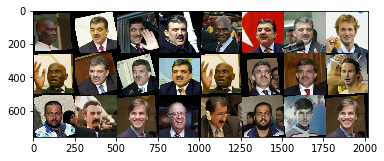

In [5]:
dataset_test = FIWDataset(image_folder.imgs[:50], transforms.ToTensor())

data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=True, num_workers=8)
example_batch = next(iter(data_loader_test))

concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
img = torchvision.utils.make_grid(concatenated)
img = img.numpy()

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

### List num image of each class

In [6]:
# num_train = int(len(image_folder.samples)*.7)
# all = {}
# for _, inx_class in image_folder.samples[num_train:]:
#     if inx_class not in all:
#         all[inx_class] = 0
#     all[inx_class] += 1
# num_class = {}
# for idx in all:
#     if all[idx] not in num_class:
#         num_class[all[idx]] = 0
#     num_class[all[idx]] += 1
# num_class

### Create train data

In [7]:
transform_train = transforms.Compose([
#                                    transforms.Resize((100,100)),
                                   transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
transform_test = transforms.Compose([
#                                    transforms.Resize((100,100)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])

num_train = int(len(image_folder.samples)*.7)
dataset_train = FIWDataset(image_folder.imgs[:num_train], transform_train)
dataset_test = FIWDataset(image_folder.imgs[num_train:], transform_test)
data_loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True, num_workers=8)

### Model

In [8]:
class LeNetOneShot(nn.Module):
    def __init__(self):
        super(LeNetOneShot, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 20, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(50*59*59, 500),
            nn.Linear(500, 10)
        )

    def forward(self, input):
        output = self.cnn(input)
        output = output.view(-1, 50*59*59)
        output = self.fc(output)
        return output
    
    def name(self):
        return "LeNetOneShot"

In [9]:
from torchvision.models import resnet34

class FaceNetModel(nn.Module):
    def __init__(self, embedding_size, num_classes, pretrained=False):
        super (FaceNetModel, self).__init__()
        
        self.model            = resnet34(pretrained)
        self.embedding_size   = embedding_size
        self.model.fc         = nn.Linear(32768 , self.embedding_size) # 2048*3*3 = 18432
        self.model.classifier = nn.Linear(self.embedding_size, num_classes)
    
    
    def l2_norm(self, input):
        input_size = input.size()
        buffer     = torch.pow(input, 2)
        normp      = torch.sum(buffer, 1).add_(1e-10)
        norm       = torch.sqrt(normp)
        _output    = torch.div(input, norm.view(-1, 1).expand_as(input))
        output     = _output.view(input_size)
    
        return output
    
    
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        
        self.features = self.l2_norm(x)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha         = 10
        self.features = self.features*alpha
        
        return self.model.classifier(self.features)

In [10]:
class TripletLoss(nn.Module):
    
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        pos_dist   = F.pairwise_distance(anchor, positive)
        neg_dist   = F.pairwise_distance(anchor, negative)
        
        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min = 0.0)
        loss       = torch.mean(hinge_dist)
        return loss

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
margin = 0.2
criterion = TripletLoss(margin).to(device)
def model_loss_func(input_data, model, phase):
    input_anchor, input_positive, input_negative = input_data
    output_anchor = model(input_anchor)
    output_positive = model(input_positive)
    output_negative = model(input_negative)
    
    if phase=='train':
        # train only semi-hard
        distance_positive = F.pairwise_distance(output_anchor, output_positive)
        distance_negative = F.pairwise_distance(output_anchor, output_negative)
        mask_hard = distance_negative < distance_positive+margin
        num_hard = mask_hard.sum()
        if num_hard == 0:
            return 0, 0, 'skip' # if not semi-hard data, return the third params means skip update weight
        output_anchor = output_anchor[mask_hard]
        output_positive = output_positive[mask_hard]
        output_negative = output_negative[mask_hard]
        #-----------------------------------
    
    
    loss = criterion(output_anchor, output_positive, output_negative)
    return (output_anchor, output_positive, output_negative), loss

### Train
***BE CAREFUL***
The accuracy depends on threshold. Right now it's unreliable. We will find the best threshold later

In [12]:
# model = LeNetOneShot()
model = FaceNetModel(embedding_size=128, num_classes=10000)

def eval_func(input_data, output, loss):
    anchor, positive, negative = output
    positive_distance = F.pairwise_distance(anchor, positive)
    negative_distance = F.pairwise_distance(anchor, negative)
    return (positive_distance < negative_distance).sum().item()
learner = Learner(data_loader_train, data_loader_test, model)
learner.fit(model_loss_func, 0.002, num_epochs=100, eval_func=eval_func, early_stop='loss')

---- epoch:0 ------
   [train] Average loss: 0.6430, acc: 21.67%
   [test] Average loss: 0.1951, acc: 74.14%
---- epoch:1 ------
   [train] Average loss: 0.3502, acc: 23.61%
   [test] Average loss: 0.1689, acc: 77.76%
---- epoch:2 ------
   [train] Average loss: 0.3927, acc: 22.57%
   [test] Average loss: 0.1607, acc: 78.69%
---- epoch:3 ------
   [train] Average loss: 0.3460, acc: 23.49%
   [test] Average loss: 0.1446, acc: 80.70%
---- epoch:4 ------
   [train] Average loss: 0.3116, acc: 20.54%
   [test] Average loss: 0.1246, acc: 83.20%
---- epoch:5 ------
   [train] Average loss: 0.2878, acc: 19.34%
   [test] Average loss: 0.1167, acc: 85.10%
---- epoch:6 ------
   [train] Average loss: 0.3712, acc: 21.07%
   [test] Average loss: 0.1661, acc: 78.20%
---- epoch:7 ------
   [train] Average loss: 0.3565, acc: 20.31%
   [test] Average loss: 0.1376, acc: 82.30%
---- epoch:8 ------
   [train] Average loss: 0.3292, acc: 18.58%
   [test] Average loss: 0.1450, acc: 82.00%
---- epoch:9 ------

### Finding threshod

In [17]:
def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        positive_distance = F.pairwise_distance(anchor, positive)
        negative_distance = F.pairwise_distance(anchor, negative)
        return (positive_distance < negative_distance).sum().item()
learner.predict(model_loss_func, eval_func) 

   [test] Average loss: 0.1166, acc: 84.87%


In [18]:
def predict_with_threshold(threshold):
    def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        
        # positive
        positive_distance = F.pairwise_distance(anchor, positive)
        positive_correct = positive_distance<threshold
        
        # negative
        negative_distance = F.pairwise_distance(anchor, negative)
        negative_correct = negative_distance>threshold
        return (positive_correct+negative_correct).sum().item()/2
    learner.predict(model_loss_func, eval_func)

In [21]:
for threshold in np.arange(0.2, 1, .1):
    print('threshold:', threshold)
    predict_with_threshold(threshold)

threshold: 0.2
   [test] Average loss: 0.1175, acc: 50.04%
threshold: 0.30000000000000004
   [test] Average loss: 0.1107, acc: 50.48%
threshold: 0.4000000000000001
   [test] Average loss: 0.1100, acc: 52.91%
threshold: 0.5000000000000001
   [test] Average loss: 0.1208, acc: 58.40%
threshold: 0.6000000000000001
   [test] Average loss: 0.1173, acc: 65.95%
threshold: 0.7000000000000002
   [test] Average loss: 0.1159, acc: 72.76%
threshold: 0.8000000000000003
   [test] Average loss: 0.1160, acc: 75.82%
threshold: 0.9000000000000001
   [test] Average loss: 0.1143, acc: 76.84%


In [23]:
predict_with_threshold(0.9)

   [test] Average loss: 0.1125, acc: 75.58%
